In [1]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat")

# Paths
input_root = "atnt_images"  # converted image folder (each s1–s40 has 10 images)
output_root = "processed_faces_newFinal11"
scale_factor = 12

# Output folders
output_with_photo = os.path.join(output_root, "with_photo")
output_without_photo = os.path.join(output_root, "without_photo")
output_shapes = os.path.join(output_root, "shapes_drawn")
os.makedirs(output_with_photo, exist_ok=True)
os.makedirs(output_without_photo, exist_ok=True)
os.makedirs(output_shapes, exist_ok=True)

# Store all data
all_features = []

print("Starting AT&T face dataset processing...")

# --- Helper functions (same as your version) ---
def draw_facial_shapes(image, landmarks):
    drawn_image = image.copy()
    thickness = 2

    # Colors
    color_eyebrows = (0, 255, 0)
    color_eyes = (255, 0, 0)
    color_nose_bridge = (0, 255, 255)
    color_nose_tip = (255, 255, 0)
    color_lips = (0, 165, 255)
    color_cheeks = (128, 0, 128)

    # Eyebrows
    for i in range(17, 21):
        cv2.line(drawn_image, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), color_eyebrows, thickness)
    for i in range(22, 26):
        cv2.line(drawn_image, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), color_eyebrows, thickness)

    # Eyes
    for eye_pts in [(36, 42), (42, 48)]:
        points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(*eye_pts)])
        if len(points) >= 5:
            try:
                (center, axes, angle) = cv2.fitEllipse(points)
                if axes[0] > 0 and axes[1] > 0:
                    cv2.ellipse(drawn_image, (int(center[0]), int(center[1])), (int(axes[0]/2), int(axes[1]/2)), angle, 0, 360, color_eyes, thickness)
            except:
                pass

    # Nose
    bridge_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(27, 31)], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [bridge_pts], True, color_nose_bridge, thickness)

    tip_pts = np.array([(landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(31).x, landmarks.part(31).y), (landmarks.part(35).x, landmarks.part(35).y)], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [tip_pts], True, color_nose_tip, thickness)

    # Lips
    outer_lip = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 60)])
    if len(outer_lip) >= 5:
        try:
            (center, axes, angle) = cv2.fitEllipse(outer_lip)
            if axes[0] > 0 and axes[1] > 0:
                cv2.ellipse(drawn_image, (int(center[0]), int(center[1])), (int(axes[0]/2), int(axes[1]/2)), angle, 0, 360, color_lips, thickness)
        except:
            pass

    # Cheeks
    left_cheek = np.array([(landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(2).x, landmarks.part(2).y), (landmarks.part(48).x, landmarks.part(48).y)], np.int32).reshape((-1, 1, 2))
    right_cheek = np.array([(landmarks.part(45).x, landmarks.part(45).y), (landmarks.part(14).x, landmarks.part(14).y), (landmarks.part(54).x, landmarks.part(54).y)], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek], True, color_cheeks, thickness)
    cv2.polylines(drawn_image, [right_cheek], True, color_cheeks, thickness)

    return drawn_image

def fit_parabola(points):
    if len(points) < 3:
        return np.nan, np.nan, np.nan
    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])
    try:
        return tuple(np.polyfit(x, y, 2))
    except:
        return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    if len(points) < 5:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    try:
        (center, axes, angle) = cv2.fitEllipse(np.array(points))
        return center[0], center[1], axes[0], axes[1], angle
    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan

# Process each subject
for subject in sorted(os.listdir(input_root)):
    subject_path = os.path.join(input_root, subject)
    if not os.path.isdir(subject_path):
        continue

    print(f"\nProcessing: {subject}")

    for img_file in os.listdir(subject_path):
        if not img_file.lower().endswith((".png", ".jpg")):
            continue

        img_path = os.path.join(subject_path, img_file)
        image = cv2.imread(img_path)

        if image is None:
            print(f"  Skipped unreadable image: {img_file}")
            continue

        upscaled = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
        gray = cv2.cvtColor(upscaled, cv2.COLOR_BGR2GRAY)

        faces = detector(gray)
        if len(faces) == 0:
            print(f"  No face found in {img_file}")
            continue

        face = faces[0]
        landmarks = predictor(gray, face)

        # Prepare output images
        with_photo = upscaled.copy()
        without_photo = np.zeros_like(upscaled)
        shapes_drawn = np.zeros_like(upscaled)

        # Draw green cross at nose
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y
        h, w = with_photo.shape[:2]
        cv2.line(with_photo, (nose_x, 0), (nose_x, h), (0, 255, 0), 1)
        cv2.line(with_photo, (0, nose_y), (w, nose_y), (0, 255, 0), 1)

        # Landmarks
        row = {'subject': subject, 'filename': img_file}
        for i in range(68):
            x, y = landmarks.part(i).x, landmarks.part(i).y
            row[f'landmark_{i}_x'] = x
            row[f'landmark_{i}_y'] = y
            cv2.circle(with_photo, (x, y), 4, (0, 0, 255), -1)
            cv2.circle(without_photo, (x, y), 4, (255, 255, 255), -1)

        # Fit and extract additional features
        row.update(dict(zip(
            ['leb_a', 'leb_b', 'leb_c'],
            fit_parabola([(landmarks.part(i).x, landmarks.part(i).y) for i in range(17, 22)])
        )))
        row.update(dict(zip(
            ['reb_a', 'reb_b', 'reb_c'],
            fit_parabola([(landmarks.part(i).x, landmarks.part(i).y) for i in range(22, 27)])
        )))
        row.update(dict(zip(
            ['left_eye_cx', 'left_eye_cy', 'left_eye_w', 'left_eye_h', 'left_eye_angle'],
            fit_ellipse_params([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)])
        )))
        row.update(dict(zip(
            ['right_eye_cx', 'right_eye_cy', 'right_eye_w', 'right_eye_h', 'right_eye_angle'],
            fit_ellipse_params([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)])
        )))
        row.update(dict(zip(
            ['outer_lip_cx', 'outer_lip_cy', 'outer_lip_w', 'outer_lip_h', 'outer_lip_angle'],
            fit_ellipse_params([(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 60)])
        )))

        # Draw shapes
        shapes_drawn = draw_facial_shapes(shapes_drawn, landmarks)

        # Save outputs
        filename = f"{subject}_{img_file}"
        cv2.imwrite(os.path.join(output_with_photo, filename), with_photo)
        cv2.imwrite(os.path.join(output_without_photo, filename), without_photo)
        cv2.imwrite(os.path.join(output_shapes, filename), shapes_drawn)

        all_features.append(row)

# Save CSV
if all_features:
    df = pd.DataFrame(all_features)
    df = df.reindex(columns=sorted(df.columns))
    csv_path = os.path.join(output_root, "facial_features_and_landmarks_data.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Facial feature data saved to: {csv_path}")
else:
    print("\n⚠️ No facial features extracted.")


Starting AT&T face dataset processing...

Processing: s1

Processing: s10

Processing: s11

Processing: s12

Processing: s13

Processing: s14

Processing: s15

Processing: s16

Processing: s17

Processing: s18

Processing: s19

Processing: s2

Processing: s20

Processing: s21

Processing: s22

Processing: s23

Processing: s24

Processing: s25

Processing: s26

Processing: s27

Processing: s28

Processing: s29

Processing: s3

Processing: s30

Processing: s31

Processing: s32

Processing: s33
  No face found in 10.png
  No face found in 4.png
  No face found in 8.png

Processing: s34

Processing: s35
  No face found in 2.png

Processing: s36

Processing: s37

Processing: s38

Processing: s39

Processing: s4

Processing: s40

Processing: s5

Processing: s6

Processing: s7

Processing: s8

Processing: s9

✅ Facial feature data saved to: processed_faces_newFinal11\facial_features_and_landmarks_data.csv


In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLDA
from sklearn.preprocessing import StandardScaler

# --- GLOBAL CONFIGURATIONS ---
# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "atnt_images" # This should point to your 'sX' folders
root_output_dir = "processed_faces_newFinal12" # Updated output directory for clarity

# Define the scaling factor for upscaling images (for Dlib part)
scale_factor = 12

# Output directory for Eigenface (PCA) and Fisherface (LDA) related visualizations and data
pca_output_dir = os.path.join(root_output_dir, "pca_analysis_results")
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")

# Ensure all output root directories exist
os.makedirs(root_output_dir, exist_ok=True)
os.makedirs(pca_output_dir, exist_ok=True)
os.makedirs(lda_output_dir, exist_ok=True)


# --- Helper Function for Drawing Shapes ---
def draw_facial_shapes(image, landmarks):
    """
    Draws different geometric shapes on a given image based on facial landmarks.
    Args:
        image (numpy.ndarray): The image on which to draw.
        landmarks (dlib.full_object_detection): Dlib's landmark object.
    Returns:
        numpy.ndarray: The image with shapes drawn.
    """
    drawn_image = image.copy()

    color_eyebrows = (0, 255, 0)
    color_eyes = (255, 0, 0)
    color_nose_bridge = (0, 255, 255)
    color_nose_tip = (255, 255, 0)
    color_lips = (0, 165, 255)
    color_cheeks = (128, 0, 128)
    thickness = 2

    # Eyebrows (polylines)
    for i in range(17, 21):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)
    for i in range(22, 26):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # Eyes (Ellipses)
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    if len(left_eye_points) >= 5:
        try:
            (center_le, axes_le, angle_le) = cv2.fitEllipse(left_eye_points)
            if axes_le[0] > 0 and axes_le[1] > 0:
                cv2.ellipse(drawn_image, (int(center_le[0]), int(center_le[1])),
                            (int(axes_le[0] / 2), int(axes_le[1] / 2)),
                            angle_le, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])
    if len(right_eye_points) >= 5:
        try:
            (center_re, axes_re, angle_re) = cv2.fitEllipse(right_eye_points)
            if axes_re[0] > 0 and axes_re[1] > 0:
                cv2.ellipse(drawn_image, (int(center_re[0]), int(center_re[1])),
                            (int(axes_re[0] / 2), int(axes_re[1] / 2)),
                            angle_re, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    # Nose Bridge (Trapezium)
    nose_bridge_pts = np.array([
        (landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
        (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_bridge_pts], True, color_nose_bridge, thickness)

    # Nose Tip (Triangle)
    nose_tip_pts = np.array([
        (landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(31).x, landmarks.part(31).y),
        (landmarks.part(35).x, landmarks.part(35).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_tip_pts], True, color_nose_tip, thickness)

    # Lips (Outer Lip Ellipse)
    outer_lip_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)])
    if len(outer_lip_points) >= 5:
        try:
            (center_ol, axes_ol, angle_ol) = cv2.fitEllipse(outer_lip_points)
            if axes_ol[0] > 0 and axes_ol[1] > 0:
                cv2.ellipse(drawn_image, (int(center_ol[0]), int(center_ol[1])),
                            (int(axes_ol[0] / 2), int(axes_ol[1] / 2)),
                            angle_ol, 0, 360, color_lips, thickness)
        except cv2.error: pass

    # Cheeks (Broader Triangles)
    left_cheek_pts = np.array([
        (landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(2).x, landmarks.part(2).y),
        (landmarks.part(48).x, landmarks.part(48).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek_pts], True, color_cheeks, thickness)

    right_cheek_pts = np.array([
        (landmarks.part(45).x, landmarks.part(45).y), (landmarks.part(14).x, landmarks.part(14).y),
        (landmarks.part(54).x, landmarks.part(54).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [right_cheek_pts], True, color_cheeks, thickness)

    return drawn_image

# --- Helper Functions for Curve Fitting ---

def fit_parabola_params(points):
    if len(points) < 3: return np.nan, np.nan, np.nan
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    try:
        with np.errstate(all='raise'):
            coefficients = np.polyfit(x_coords, y_coords, 2)
            return tuple(coefficients)
    except Exception: return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    if len(points) < 5: return np.nan, np.nan, np.nan, np.nan, np.nan
    points_np = np.array(points, dtype=np.int32)
    try:
        (center, axes, angle) = cv2.fitEllipse(points_np)
        if axes[0] <= 0 or axes[1] <= 0: return np.nan, np.nan, np.nan, np.nan, np.nan
        return center[0], center[1], axes[0], axes[1], angle
    except cv2.error: return np.nan, np.nan, np.nan, np.nan, np.nan
    except Exception: return np.nan, np.nan, np.nan, np.nan, np.nan
    

# --- Main Processing Loop for Dlib, Drawing, and Initial Feature Extraction ---
print("Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...")

all_facial_features_data = []

# Assuming AT&T dataset structure: root_input_dir/sX/Y.pgm
person_folders = [d for d in os.listdir(root_input_dir) if os.path.isdir(os.path.join(root_input_dir, d))]
person_folders.sort(key=lambda x: int(x[1:])) # Sort numerically, e.g., s1, s2, ..., s40

for person_id in person_folders:
    input_person_path = os.path.join(root_input_dir, person_id)

    # Output directories specific to each person
    output_with_photo_path = os.path.join(root_output_dir, person_id, "with_photo")
    output_without_photo_path = os.path.join(root_output_dir, person_id, "without_photo")
    output_shapes_drawn_path = os.path.join(root_output_dir, person_id, "shapes_drawn")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    os.makedirs(output_shapes_drawn_path, exist_ok=True)

    print(f"\nProcessing person: {person_id}...")

    for filename in os.listdir(input_person_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".pgm")): # Added .pgm for AT&T
            image_path = os.path.join(input_person_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                current_image_features = {'person_id': person_id, 'filename': filename}

                # Collect raw landmark data
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    current_image_features[f'landmark_{n}_x'] = x
                    current_image_features[f'landmark_{n}_y'] = y

                # Apply Curve Fitting Algorithms and Store Parameters
                leb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 22)]
                a_leb, b_leb, c_leb = fit_parabola_params(leb_points)
                current_image_features['leb_parabola_a'] = a_leb
                current_image_features['leb_parabola_b'] = b_leb
                current_image_features['leb_parabola_c'] = c_leb

                reb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(22, 27)]
                a_reb, b_reb, c_reb = fit_parabola_params(reb_points)
                current_image_features['reb_parabola_a'] = a_reb
                current_image_features['reb_parabola_b'] = b_reb
                current_image_features['reb_parabola_c'] = c_reb

                le_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                cx_le, cy_le, maj_le, min_le, ang_le = fit_ellipse_params(le_points)
                current_image_features['le_ellipse_center_x'] = cx_le; current_image_features['le_ellipse_center_y'] = cy_le
                current_image_features['le_ellipse_major_axis'] = maj_le; current_image_features['le_ellipse_minor_axis'] = min_le
                current_image_features['le_ellipse_angle'] = ang_le

                re_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                cx_re, cy_re, maj_re, min_re, ang_re = fit_ellipse_params(re_points)
                current_image_features['re_ellipse_center_x'] = cx_re; current_image_features['re_ellipse_center_y'] = cy_re
                current_image_features['re_ellipse_major_axis'] = maj_re; current_image_features['re_ellipse_minor_axis'] = min_re
                current_image_features['re_ellipse_angle'] = ang_re

                ol_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)]
                cx_ol, cy_ol, maj_ol, min_ol, ang_ol = fit_ellipse_params(ol_points)
                current_image_features['ol_ellipse_center_x'] = cx_ol; current_image_features['ol_ellipse_center_y'] = cy_ol
                current_image_features['ol_ellipse_major_axis'] = maj_ol; current_image_features['ol_ellipse_minor_axis'] = min_ol
                current_image_features['ol_ellipse_angle'] = ang_ol

                # Nose Bridge (Trapezium - extract vertices)
                current_image_features['nose_bridge_v1_x'] = landmarks.part(27).x; current_image_features['nose_bridge_v1_y'] = landmarks.part(27).y
                current_image_features['nose_bridge_v2_x'] = landmarks.part(28).x; current_image_features['nose_bridge_v2_y'] = landmarks.part(28).y
                current_image_features['nose_bridge_v3_x'] = landmarks.part(29).x; current_image_features['nose_bridge_v3_y'] = landmarks.part(29).y
                current_image_features['nose_bridge_v4_x'] = landmarks.part(30).x; current_image_features['nose_bridge_v4_y'] = landmarks.part(30).y

                # Nose Tip (Triangle - extract vertices)
                current_image_features['nose_tip_v1_x'] = landmarks.part(30).x; current_image_features['nose_tip_v1_y'] = landmarks.part(30).y
                current_image_features['nose_tip_v2_x'] = landmarks.part(31).x; current_image_features['nose_tip_v2_y'] = landmarks.part(31).y
                current_image_features['nose_tip_v3_x'] = landmarks.part(35).x; current_image_features['nose_tip_v3_y'] = landmarks.part(35).y

                # Left Cheek (Triangle - extract vertices)
                current_image_features['left_cheek_v1_x'] = landmarks.part(36).x; current_image_features['left_cheek_v1_y'] = landmarks.part(36).y
                current_image_features['left_cheek_v2_x'] = landmarks.part(2).x; current_image_features['left_cheek_v2_y'] = landmarks.part(2).y
                current_image_features['left_cheek_v3_x'] = landmarks.part(48).x; current_image_features['left_cheek_v3_y'] = landmarks.part(48).y

                # Right Cheek (Triangle - extract vertices)
                current_image_features['right_cheek_v1_x'] = landmarks.part(45).x; current_image_features['right_cheek_v1_y'] = landmarks.part(45).y
                current_image_features['right_cheek_v2_x'] = landmarks.part(14).x; current_image_features['right_cheek_v2_y'] = landmarks.part(14).y
                current_image_features['right_cheek_v3_x'] = landmarks.part(54).x; current_image_features['right_cheek_v3_y'] = landmarks.part(54).y

                all_facial_features_data.append(current_image_features)

                # Visualizations
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                drawn_image_shapes_only = np.zeros(upscaled_image.shape, dtype=np.uint8)

                # Draw quadrant lines
                nose_x = landmarks.part(30).x; nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                # Draw landmarks and labels
                drawn_index = 1; seen = set()
                for n in range(68):
                    x = landmarks.part(n).x; y = landmarks.part(n).y
                    if (x, y) in seen: continue
                    seen.add((x, y))
                    circle_radius = 2; fill_type = -1
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: offset_y = -10
                    elif n == 49: offset_x = -20; offset_y = 6
                    elif n == 50: offset_x = 0; offset_y = -8
                    elif n == 65: offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54: offset_y = -8
                    elif 55 <= n <= 59: offset_y = 10
                    elif 60 <= n <= 64: offset_y = -8
                    elif 65 <= n <= 67: offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, (0, 0, 255), fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1, cv2.LINE_AA)
                    drawn_index += 1

                drawn_image_shapes_only = draw_facial_shapes(drawn_image_shapes_only, landmarks)

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                output_image_path_shapes_drawn = os.path.join(output_shapes_drawn_path, filename)
                cv2.imwrite(output_image_path_shapes_drawn, drawn_image_shapes_only)

            else:
                print(f"  No face detected in {filename} from {person_id} folder.")

print("\nStage 1: Dlib processing, shape drawing, and initial feature extraction complete!")

# Save all collected facial feature data to a single CSV file
if all_facial_features_data:
    df = pd.DataFrame(all_facial_features_data)
    df = df.reindex(columns=sorted(df.columns))
    csv_output_path = os.path.join(root_output_dir, "facial_features_and_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates and fitted shape parameters saved to: {csv_output_path}")
else:
    print("No facial feature data was collected in Stage 1.")
    

# --- Configuration for Eigenface Decomposition (PCA) ---
# Define the target size for all face images (Width, Height)
face_target_size = (100, 100) # Keep consistent

# Number of top Eigenfaces to retain
num_eigenfaces_to_keep = 100 # Can be adjusted, often > number of classes for LDA input

# --- Step 1: Data Preparation for Eigenfaces ---
print("\nStarting Stage 2: Eigenface Decomposition (PCA)...")
print("Step 1: Collecting and preprocessing face images for PCA...")

all_face_vectors = []
image_metadata_pca = [] # Use a separate list for PCA metadata

for person_id in person_folders:
    # Read from the '_shapes_drawn' folder, as these are upscaled and have shapes,
    # but more importantly, they are already resized consistently by the previous step's upscaling.
    person_dir = os.path.join(root_output_dir, person_id, "shapes_drawn")
    if not os.path.exists(person_dir):
        print(f"Warning: Directory '{person_dir}' not found. Skipping {person_id} for PCA.")
        continue

    for filename in os.listdir(person_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".pgm")):
            image_path = os.path.join(person_dir, filename)
            img = cv2.imread(image_path)

            if img is None:
                print(f"Warning: Could not read image {image_path}. Skipping for PCA.")
                continue

            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to uniform size
            resized_face = cv2.resize(gray_img, face_target_size, interpolation=cv2.INTER_AREA)

            # Flatten the 2D image into a 1D vector
            flattened_face = resized_face.flatten()

            all_face_vectors.append(flattened_face)
            # Store person_id as the label for LDA later
            image_metadata_pca.append({'person_id': person_id, 'filename': filename})

if not all_face_vectors:
    print("No face images found or processed for Eigenface decomposition. Exiting.")
else:
    X = np.array(all_face_vectors, dtype=np.float64)
    num_images, num_pixels = X.shape
    print(f"Collected {num_images} images, each with {num_pixels} pixels for PCA.")

    # --- Step 2: Calculate the Mean Face ---
    print("Step 2: Calculating the mean face...")
    mean_face_vector = np.mean(X, axis=0)
    mean_face_image = mean_face_vector.reshape(face_target_size)

    plt.figure(figsize=(4, 4))
    plt.imshow(mean_face_image, cmap='gray')
    plt.title("Mean Face")
    plt.axis('off')
    mean_face_path = os.path.join(pca_output_dir, "mean_face.png")
    plt.savefig(mean_face_path)
    plt.close()
    print(f"Mean face saved to: {mean_face_path}")

    # --- Step 3: Subtract the Mean Face ---
    print("Step 3: Centering the data (subtracting mean face)...")
    X_centered = X - mean_face_vector

    # --- Step 4 & 5: Compute Eigenvalues and Eigenvectors ---
    print("Step 4 & 5: Computing eigenvectors and eigenvalues...")
    S_matrix = X_centered @ X_centered.T # N x N scatter matrix
    eigenvalues_small, eigenvectors_small = np.linalg.eigh(S_matrix)

    sorted_indices = np.argsort(eigenvalues_small)[::-1]
    eigenvalues_small = eigenvalues_small[sorted_indices]
    eigenvectors_small = eigenvectors_small[:, sorted_indices]

    eigenfaces_raw = X_centered.T @ eigenvectors_small
    eigenfaces = eigenfaces_raw / np.linalg.norm(eigenfaces_raw, axis=0) # Normalize

    print("Eigenvalues and eigenvectors computed.")

    # --- Step 6: Select Principal Components (Eigenfaces) ---
    print(f"Step 6: Selecting top {num_eigenfaces_to_keep} Eigenfaces...")
    selected_eigenfaces = eigenfaces[:, :num_eigenfaces_to_keep]
    selected_eigenvalues = eigenvalues_small[:num_eigenfaces_to_keep]

    print("Visualizing top Eigenfaces...")
    fig, axes = plt.subplots(1, min(num_eigenfaces_to_keep, 10), figsize=(20, 4))
    for i, ax in enumerate(axes):
        eigenface_img = selected_eigenfaces[:, i].reshape(face_target_size)
        ax.imshow(eigenface_img, cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
        ax.axis('off')
    plt.tight_layout()
    eigenfaces_plot_path = os.path.join(pca_output_dir, "top_eigenfaces.png")
    plt.savefig(eigenfaces_plot_path)
    plt.close()
    print(f"Top Eigenfaces visualization saved to: {eigenfaces_plot_path}")

    # --- Step 7: Project Faces onto Eigenface Space ---
    print("Step 7: Projecting original faces onto Eigenface space...")
    feature_vectors = X_centered @ selected_eigenfaces
    print(f"Projected {num_images} faces into a {num_eigenfaces_to_keep}-dimensional Eigenface space.")

    # --- Step 8: Store Eigenfaces and Feature Vectors ---
    print("Step 8: Storing feature vectors in CSV...")
    df_features = pd.DataFrame(feature_vectors)
    df_features.columns = [f'eigen_feature_{i}' for i in range(num_eigenfaces_to_keep)]
    df_metadata = pd.DataFrame(image_metadata_pca) # Use the correct metadata list for PCA
    final_df_pca = pd.concat([df_metadata, df_features], axis=1)

    features_csv_path_pca = os.path.join(pca_output_dir, "eigenface_features.csv")
    final_df_pca.to_csv(features_csv_path_pca, index=False)

    print(f"Eigenface feature vectors saved to: {features_csv_path_pca}")
    print("Stage 2: Eigenface decomposition (PCA) complete!")


# --- Linear Discriminant Analysis (LDA) on PCA Features ---
print("\nStarting Stage 3: Linear Discriminant Analysis (LDA)...")

# Input CSV from Eigenface decomposition
eigenface_features_csv_path = os.path.join(pca_output_dir, "eigenface_features.csv")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# --- Step 1: Load PCA Feature Vectors and Labels ---
print("Step 1: Loading Eigenface features and labels for LDA...")

try:
    df_eigen_features = pd.read_csv(eigenface_features_csv_path)
except FileNotFoundError:
    print(f"Error: Eigenface features CSV not found at {eigenface_features_csv_path}. Please run Eigenface decomposition first.")
    exit() # Exit if PCA features aren't available

# Separate features (X) and labels (y)
feature_cols = [col for col in df_eigen_features.columns if col.startswith('eigen_feature_')]
X_pca = df_eigen_features[feature_cols].values # NumPy array of PCA features
y_labels = df_eigen_features['person_id'].values # Use 'person_id' as labels for LDA
filenames_lda = df_eigen_features['filename'].values # Keep filenames for final CSV

print(f"Loaded {X_pca.shape[0]} samples with {X_pca.shape[1]} PCA features.")

# Map person_id strings to numerical labels for easier processing
unique_person_ids = np.unique(y_labels)
person_id_to_int = {pid: i for i, pid in enumerate(unique_person_ids)}
y_numeric = np.array([person_id_to_int[pid] for pid in y_labels])

num_classes = len(unique_person_ids)
print(f"Detected {num_classes} classes (persons): {unique_person_ids}")

# --- Step 2: Apply LDA using Scikit-learn ---
print("Step 2: Applying LDA using Scikit-learn...")

# It's good practice to scale features before LDA, especially if using a classifier later
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# The maximum number of components for LDA is min(n_samples - n_classes, n_classes - 1)
# For the AT&T dataset (40 classes), max components will be 39.
# We set n_components to min(n_classes - 1, original_features_dim)
n_components_lda = min(num_classes - 1, X_pca.shape[1])
if n_components_lda <= 0:
    print("Not enough classes or features for meaningful LDA. Skipping LDA projection.")
    exit()

lda = SKLDA(n_components=n_components_lda)
X_lda_features = lda.fit_transform(X_pca_scaled, y_numeric) # Fit and transform

print(f"Projected data into {X_lda_features.shape[1]}-dimensional LDA (Fisherface) space.")

# --- Step 3: Visualize Fisherfaces (LDA Components) ---
# Note: Visualizing Fisherfaces is more complex than Eigenfaces directly from LDA components.
# Fisherfaces are linear combinations of the original pixel space.
# To get Fisherfaces, we need the transformation matrix (W_LDA) that projects from the *original pixel space*
# to the LDA subspace, typically computed as W_LDA = Eigenfaces @ LDA_eigenvectors.
# However, since we applied LDA on PCA features (X_pca), the lda.coef_ (which is W_LDA) is in the PCA feature space.
# To visualize in pixel space, we'd multiply lda.coef_ by the selected_eigenfaces.

print("Visualizing top Fisherfaces (LDA Components)...")
# lda.coef_ gives the unscaled coefficients. We need to apply inverse scaling if used, or work with original.
# If you didn't scale before PCA, then the direct `selected_eigenfaces` can be used.
# But since we scaled `X_pca` for LDA, `lda.coef_` represents directions in the *scaled PCA space*.
# To get back to original pixel space, we would typically do:
# Fisherfaces (in pixel space) = selected_eigenfaces @ lda.scalings_
# where lda.scalings_ is the transformation matrix from the (scaled) PCA space to LDA space.
# Note: `lda.scalings_` in scikit-learn's LDA is the transformation matrix.

# Rescale lda.scalings_ by the original feature scaling (from StandardScaler) to properly back-project.
# Each column of lda.scalings_ is an LDA component in the scaled PCA space.
# To visualize these in the original pixel space, you must transform them back through PCA.
# The transformation from scaled PCA features back to original centered images is:
# pixel_fisherface = (scaler.inverse_transform(lda.scalings_.T) @ selected_eigenfaces.T).T (conceptual)
# A more direct approach for visualization, assuming lda.components_ are what we want to visualize as "Fisherfaces":
# lda.components_ are the normalized components directly, but they are in the *scaled* PCA space.
# We need to project these back to the original pixel space.
# The transformation from scaled PCA space to original pixel space is roughly `scaler.inverse_transform(lda_component_in_scaled_pca_space) @ selected_eigenfaces.T`.

# A simplified, commonly accepted way for visualization when PCA is a preprocessing step:
# The `lda.coef_` attribute *can* be interpreted as the direction vectors in the original feature space (PCA space here).
# To visualize them as images (Fisherfaces), we project them back through the PCA transformation.
# This assumes `lda.coef_` corresponds to the unscaled basis vectors in the PCA space.
# The `lda.scalings_` attribute is better if you want the components that define the LDA subspace,
# but it's often more complex to visualize directly because they are typically scaled.

# Let's use lda.scalings_ which represents the transformation from the pre-processed (scaled PCA) space to the LDA space.
# To visualize them as "Fisherfaces" in the original pixel space, we apply the inverse of PCA projection.
# This is equivalent to: Fisherface_i = Sum( Eigenface_j * LDA_Component_ij )
# So, the Fisherfaces in original pixel space are `selected_eigenfaces @ lda.scalings_`
# The columns of `lda.scalings_` are the eigenvectors of Sw^-1 Sb relative to the scaled PCA space.

# For visualization, we take the top components from `lda.scalings_` and project them back.
# The `lda.scalings_` are the linear discriminant vectors in the PCA feature space.
# To get them into the image space, we multiply by the selected Eigenfaces.
# Note that this visualization will depend on how many Eigenfaces were kept.
fisherfaces_pixel_space = selected_eigenfaces @ lda.scalings_

fig, axes = plt.subplots(1, min(X_lda_features.shape[1], 10), figsize=(20, 4))
if X_lda_features.shape[1] == 1: # Handle case with only one component
    axes = [axes]
for i, ax in enumerate(axes):
    fisherface_img = fisherfaces_pixel_space[:, i].reshape(face_target_size)
    # Normalize for better visualization (min-max scaling to 0-255 or 0-1)
    fisherface_img = cv2.normalize(fisherface_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    ax.imshow(fisherface_img, cmap='gray')
    ax.set_title(f'Fisherface {i+1}')
    ax.axis('off')
plt.tight_layout()
fisherfaces_plot_path = os.path.join(lda_output_dir, "top_fisherfaces.png")
plt.savefig(fisherfaces_plot_path)
plt.close()
print(f"Top Fisherfaces visualization saved to: {fisherfaces_plot_path}")

# --- Step 4: Store LDA Features ---
print("Step 4: Storing LDA feature vectors in CSV...")

df_lda_features = pd.DataFrame(X_lda_features)
df_lda_features.columns = [f'lda_feature_{i}' for i in range(X_lda_features.shape[1])]

# Add original metadata (person_id, filename) back
df_metadata_lda = pd.DataFrame({'person_id': y_labels, 'filename': filenames_lda})
final_df_lda = pd.concat([df_metadata_lda, df_lda_features], axis=1)

final_df_lda.to_csv(lda_features_csv_path, index=False)

print(f"LDA feature vectors saved to: {lda_features_csv_path}")
print("Stage 3: Linear Discriminant Analysis (LDA) complete!")

Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...

Processing person: s1...

Processing person: s2...

Processing person: s3...

Processing person: s4...

Processing person: s5...

Processing person: s6...

Processing person: s7...

Processing person: s8...

Processing person: s9...

Processing person: s10...

Processing person: s11...

Processing person: s12...

Processing person: s13...

Processing person: s14...

Processing person: s15...

Processing person: s16...

Processing person: s17...

Processing person: s18...

Processing person: s19...

Processing person: s20...

Processing person: s21...

Processing person: s22...

Processing person: s23...

Processing person: s24...

Processing person: s25...

Processing person: s26...

Processing person: s27...

Processing person: s28...

Processing person: s29...

Processing person: s30...

Processing person: s31...

Processing person: s32...

Processing person: s33...
  No face detected in 10.png fr

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

# --- Configuration ---
# Path to the LDA features CSV generated from the previous script
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# --- Step 1: Load the LDA Features ---
print("Starting Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values  # Features
y = df_lda_features['person_id'].values   # Labels (person IDs)

# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- Step 4: Initialize and Train KNN Model ---
n_neighbors = 5
print(f"Initializing K-Nearest Neighbors (KNN) model with k={n_neighbors}...")
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

print("Training KNN model...")
knn_model.fit(X_train, y_train)
print("KNN model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test = knn_model.predict(X_test)
print("Predictions on test set complete.")

# --- Make predictions on the training set as well ---
print("Making predictions on the training set (for training accuracy)...")
y_pred_train = knn_model.predict(X_train)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- KNN Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score for each class on test set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))

# Confusion Matrix (Test Set)
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (Test Set):")
# You can uncomment this line if you want to see the full matrix
# print(conf_matrix)

# Example: Display a sample of true vs. predicted for test set
print("\nSample of True vs. Predicted Labels (Test Set):")
for i in range(min(10, len(y_test))): # Display first 10 predictions
    print(f"True: {y_test[i]:<5} | Predicted: {y_pred_test[i]}")

print("\nK-Nearest Neighbors (KNN) model evaluation complete.")

Starting Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Initializing K-Nearest Neighbors (KNN) model with k=5...
Training KNN model...
KNN model training complete.
Making predictions on the test set...
Predictions on test set complete.
Making predictions on the training set (for training accuracy)...
Predictions on training set complete.

--- KNN Model Evaluation ---
Training Accuracy: 0.7658
Testing Accuracy: 0.5125

Classification Report (Test Set):
              precision    recall  f1-score   support

          s1       0.20      0.50      0.29         2
         s10       1.00      1.00      1.00         2
         s11       0.50      1.00      0.67         2
         s12       1.00      1.00      1.00         2
         s13    

Starting Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Initializing K-Nearest Neighbors (KNN) model with k=5...
Training KNN model...
KNN model training complete.
Making predictions on the test set...
Predictions on test set complete.
Making predictions on the training set (for training accuracy)...
Predictions on training set complete.

--- KNN Model Evaluation ---
Training Accuracy: 0.7658
Testing Accuracy: 0.5125

Classification Report (Test Set):
              precision    recall  f1-score   support

          s1       0.20      0.50      0.29         2
         s10       1.00      1.00      1.00         2
         s11       0.50      1.00      0.67         2
         s12       1.00      1.00      1.00         2
         s13    

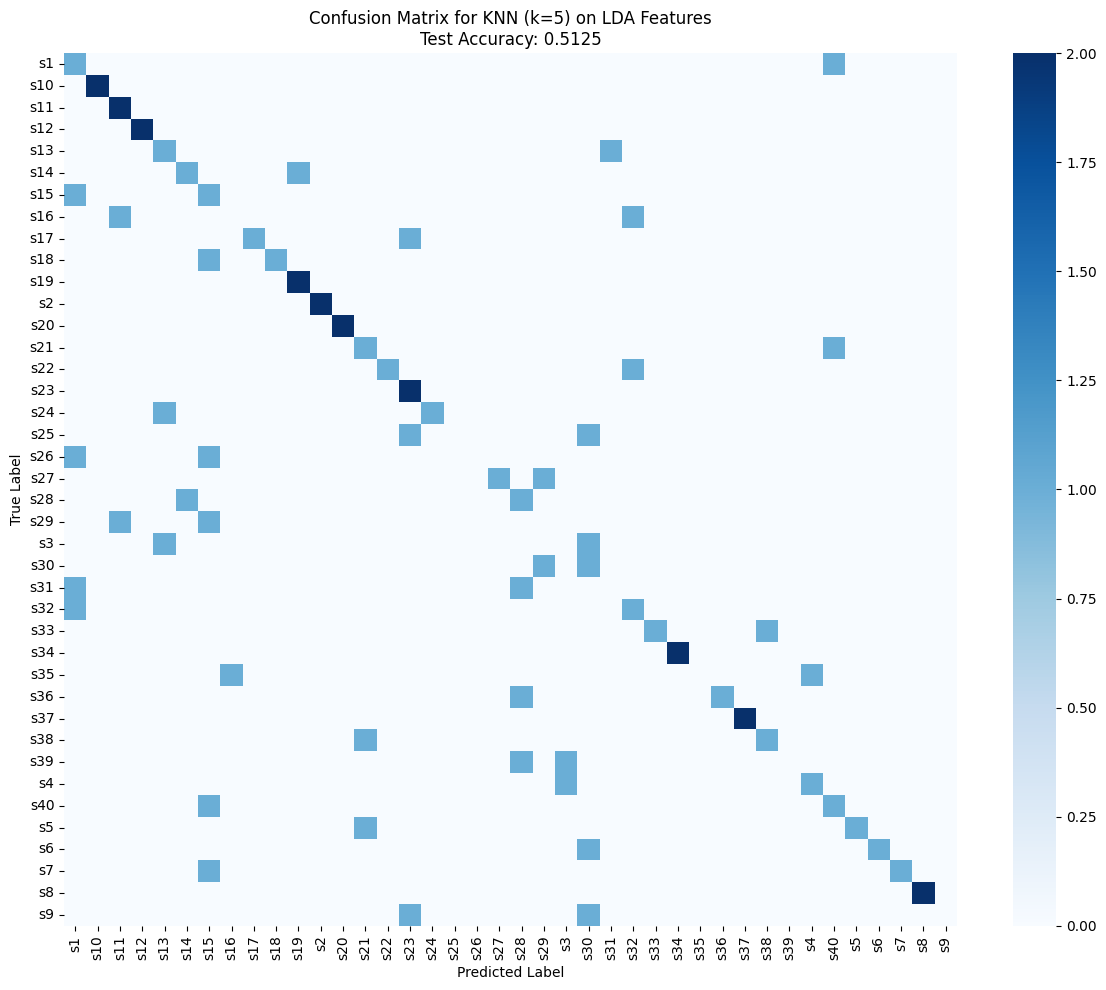

Graphical Confusion Matrix saved to: processed_faces_newFinal12\lda_analysis_results\plots\knn_confusion_matrix_k5.png

Sample of True vs. Predicted Labels (Test Set):
True: s37   | Predicted: s37
True: s16   | Predicted: s11
True: s25   | Predicted: s30
True: s5    | Predicted: s5
True: s28   | Predicted: s14
True: s36   | Predicted: s28
True: s12   | Predicted: s12
True: s33   | Predicted: s38
True: s1    | Predicted: s40
True: s12   | Predicted: s12

K-Nearest Neighbors (KNN) model evaluation complete.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Path to the LDA features CSV generated from the previous script
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# Directory to save plots
plots_output_dir = os.path.join(lda_output_dir, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# --- Step 1: Load the LDA Features ---
print("Starting Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values  # Features
y = df_lda_features['person_id'].values   # Labels (person IDs)

# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- Step 4: Initialize and Train KNN Model ---
n_neighbors = 5
print(f"Initializing K-Nearest Neighbors (KNN) model with k={n_neighbors}...")
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

print("Training KNN model...")
knn_model.fit(X_train, y_train)
print("KNN model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test = knn_model.predict(X_test)
print("Predictions on test set complete.")

print("Making predictions on the training set (for training accuracy)...")
y_pred_train = knn_model.predict(X_train)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- KNN Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score for each class on test set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))

# --- Graphical Confusion Matrix ---
print("\nGenerating graphical Confusion Matrix...")

# Get unique class labels for clearer axes
class_labels = np.unique(y) # All possible person_id labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=class_labels)

# Set up the matplotlib figure and axes
plt.figure(figsize=(12, 10)) # Adjust size based on number of classes

# Create the heatmap
sns.heatmap(
    conf_matrix,
    annot=False,  # Set to True if you want to see numbers on cells (might be cluttered for 40 classes)
    fmt='d',      # Format as integers
    cmap='Blues', # Color map (e.g., 'Blues', 'viridis', 'YlGnBu')
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for KNN (k={n_neighbors}) on LDA Features\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout() # Adjust plot to ensure everything fits

# Save the plot
confusion_matrix_plot_path = os.path.join(plots_output_dir, f"knn_confusion_matrix_k{n_neighbors}.png")
plt.savefig(confusion_matrix_plot_path)
plt.show() # Display the plot
plt.close() # Close the plot to free memory

print(f"Graphical Confusion Matrix saved to: {confusion_matrix_plot_path}")

# Example: Display a sample of true vs. predicted for test set
print("\nSample of True vs. Predicted Labels (Test Set):")
for i in range(min(10, len(y_test))): # Display first 10 predictions
    print(f"True: {y_test[i]:<5} | Predicted: {y_pred_test[i]}")

print("\nK-Nearest Neighbors (KNN) model evaluation complete.")

Starting SVM Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Scaling features using StandardScaler...
Feature scaling complete.
Initializing Support Vector Machine (SVM) model with RBF kernel...
Training SVM model...
SVM model training complete.
Making predictions on the test set...
Predictions on test set complete.
Making predictions on the training set (for training accuracy)...
Predictions on training set complete.

--- SVM Model Evaluation ---
Training Accuracy: 0.9937
Testing Accuracy: 0.6125

Classification Report (Test Set):
              precision    recall  f1-score   support

          s1       1.00      0.50      0.67         2
         s10       1.00      1.00      1.00         2
         s11       0.67      1.00      0.80

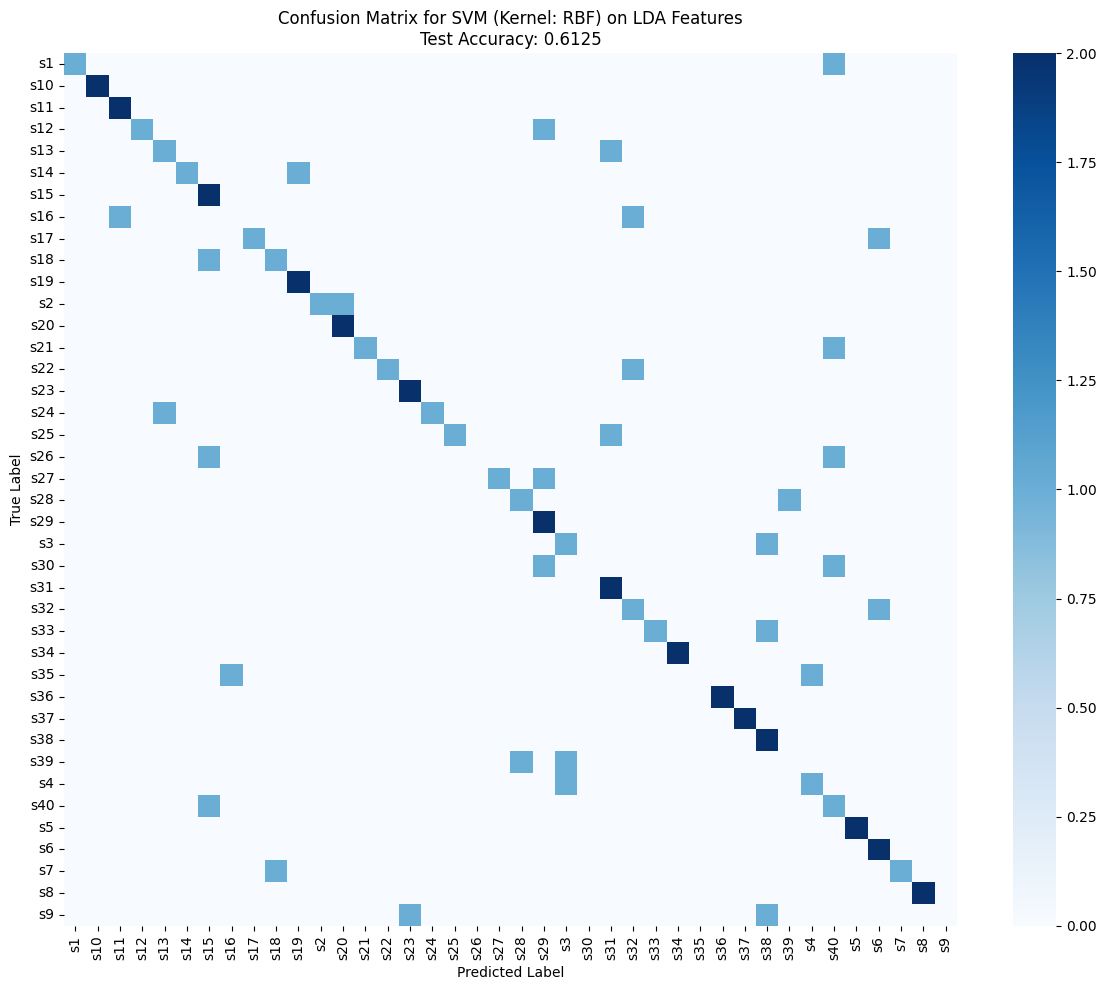

Graphical Confusion Matrix saved to: processed_faces_newFinal12\lda_analysis_results\plots\svm_confusion_matrix_rbf.png

Sample of True vs. Predicted Labels (Test Set):
True: s37   | Predicted: s37
True: s16   | Predicted: s11
True: s25   | Predicted: s31
True: s5    | Predicted: s5
True: s28   | Predicted: s39
True: s36   | Predicted: s36
True: s12   | Predicted: s12
True: s33   | Predicted: s38
True: s1    | Predicted: s40
True: s12   | Predicted: s29

Support Vector Machine (SVM) model evaluation complete.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler # Important for SVM

# --- Configuration ---
# Path to the LDA features CSV generated from the previous script
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# Directory to save plots
plots_output_dir = os.path.join(lda_output_dir, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# --- Step 1: Load the LDA Features ---
print("Starting SVM Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values  # Features
y = df_lda_features['person_id'].values   # Labels (person IDs)

# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- IMPORTANT FOR SVM: Feature Scaling ---
# SVMs are sensitive to the scale of features. It's good practice to scale
# your data before training an SVM, especially with kernels like RBF.
print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Apply the same scaling to the test set

print("Feature scaling complete.")

# --- Step 4: Initialize and Train SVM Model ---
# We'll start with an RBF kernel. You can experiment with 'linear', 'poly', 'sigmoid'
# 'C' is the regularization parameter. A smaller C promotes a wider margin.
# 'gamma' defines how much influence a single training example has.
print("Initializing Support Vector Machine (SVM) model with RBF kernel...")
# You might need to tune C and gamma later using GridSearchCV for optimal performance
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42) # 'scale' uses 1 / (n_features * X.var())

print("Training SVM model...")
svm_model.fit(X_train_scaled, y_train)
print("SVM model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test = svm_model.predict(X_test_scaled)
print("Predictions on test set complete.")

print("Making predictions on the training set (for training accuracy)...")
y_pred_train = svm_model.predict(X_train_scaled)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- SVM Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score for each class on test set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))

# --- Graphical Confusion Matrix ---
print("\nGenerating graphical Confusion Matrix...")

class_labels = np.unique(y) # All possible person_id labels
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for SVM (Kernel: RBF) on LDA Features\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout()

# Save the plot
confusion_matrix_plot_path = os.path.join(plots_output_dir, "svm_confusion_matrix_rbf.png")
plt.savefig(confusion_matrix_plot_path)
plt.show()
plt.close()

print(f"Graphical Confusion Matrix saved to: {confusion_matrix_plot_path}")

# Example: Display a sample of true vs. predicted for test set
print("\nSample of True vs. Predicted Labels (Test Set):")
for i in range(min(10, len(y_test))):
    print(f"True: {y_test[i]:<5} | Predicted: {y_pred_test[i]}")

print("\nSupport Vector Machine (SVM) model evaluation complete.")

Starting Random Forest Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Initializing Random Forest Classifier...
Training Random Forest model...
Random Forest model training complete.
Making predictions on the test set...
Predictions on test set complete.
Making predictions on the training set (for training accuracy)...
Predictions on training set complete.

--- Random Forest Model Evaluation ---
Training Accuracy: 1.0000
Testing Accuracy: 0.5750

Classification Report (Test Set):
              precision    recall  f1-score   support

          s1       0.00      0.00      0.00         2
         s10       1.00      1.00      1.00         2
         s11       0.50      1.00      0.67         2
         s12       1.00      1.00      1.0

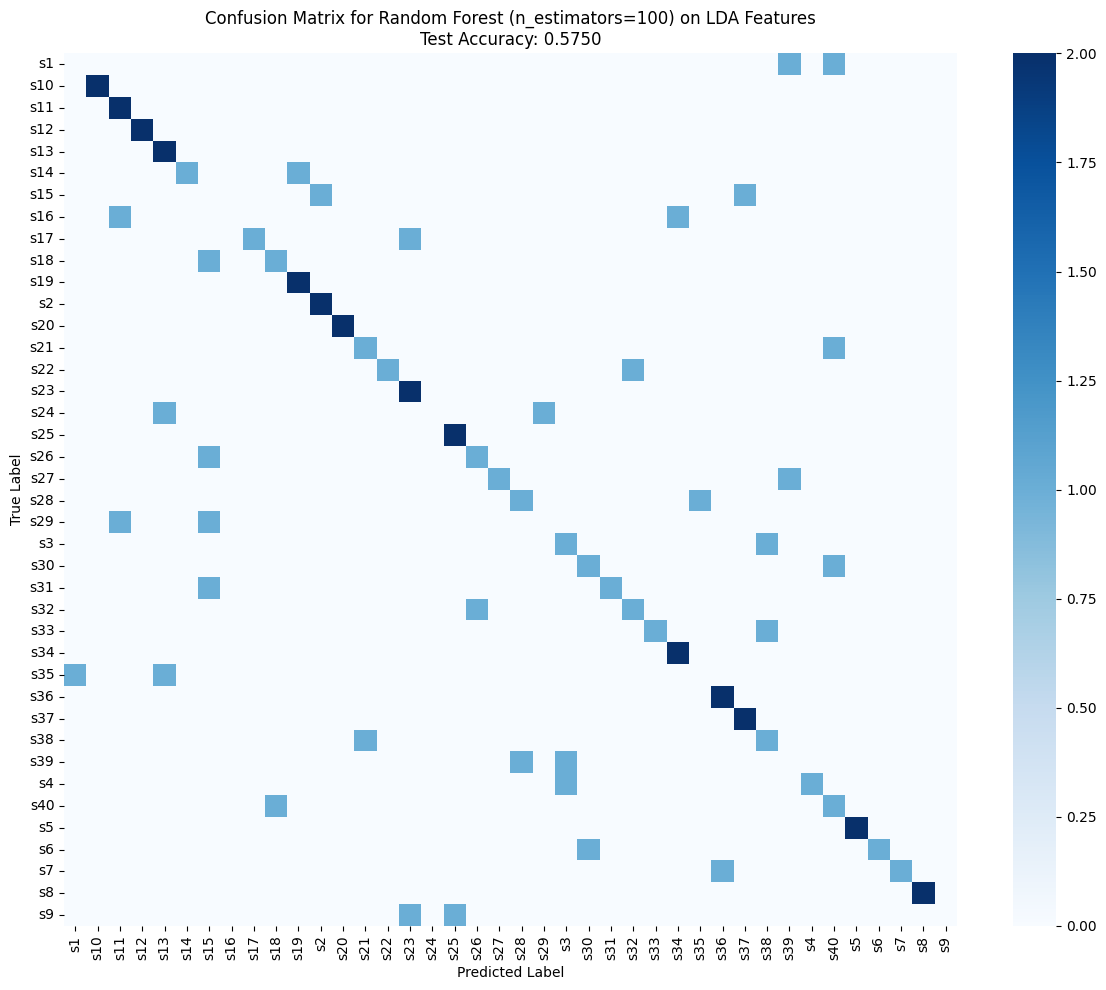

Graphical Confusion Matrix saved to: processed_faces_newFinal12\lda_analysis_results\plots\random_forest_confusion_matrix.png

Sample of True vs. Predicted Labels (Test Set):
True: s37   | Predicted: s37
True: s16   | Predicted: s11
True: s25   | Predicted: s25
True: s5    | Predicted: s5
True: s28   | Predicted: s35
True: s36   | Predicted: s36
True: s12   | Predicted: s12
True: s33   | Predicted: s38
True: s1    | Predicted: s40
True: s12   | Predicted: s12

Random Forest Classifier model evaluation complete.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Import RandomForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Path to the LDA features CSV generated from the previous script
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# Directory to save plots
plots_output_dir = os.path.join(lda_output_dir, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# --- Step 1: Load the LDA Features ---
print("Starting Random Forest Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values  # Features
y = df_lda_features['person_id'].values   # Labels (person IDs)

# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- Step 4: Initialize and Train Random Forest Model ---
# n_estimators: The number of trees in the forest. More trees generally lead to better performance
#               but also slower training.
# random_state: For reproducibility.
print("Initializing Random Forest Classifier...")
# You might tune n_estimators, max_depth, min_samples_split, etc., later.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test = rf_model.predict(X_test)
print("Predictions on test set complete.")

print("Making predictions on the training set (for training accuracy)...")
y_pred_train = rf_model.predict(X_train)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- Random Forest Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score for each class on test set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))

# --- Graphical Confusion Matrix ---
print("\nGenerating graphical Confusion Matrix...")

class_labels = np.unique(y) # All possible person_id labels
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Random Forest (n_estimators=100) on LDA Features\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout()

# Save the plot
confusion_matrix_plot_path = os.path.join(plots_output_dir, "random_forest_confusion_matrix.png")
plt.savefig(confusion_matrix_plot_path)
plt.show()
plt.close()

print(f"Graphical Confusion Matrix saved to: {confusion_matrix_plot_path}")

# Example: Display a sample of true vs. predicted for test set
print("\nSample of True vs. Predicted Labels (Test Set):")
for i in range(min(10, len(y_test))):
    print(f"True: {y_test[i]:<5} | Predicted: {y_pred_test[i]}")

print("\nRandom Forest Classifier model evaluation complete.")

Starting Random Forest Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Initializing Random Forest Classifier with n_estimators=100, max_depth=10, min_samples_leaf=2...
Training Random Forest model...
Random Forest model training complete.
Making predictions on the test set...
Predictions on test set complete.
Making predictions on the training set (for training accuracy)...
Predictions on training set complete.

--- Random Forest Model Evaluation ---
Training Accuracy: 1.0000
Testing Accuracy: 0.6125

Classification Report (Test Set):
              precision    recall  f1-score   support

          s1       0.00      0.00      0.00         2
         s10       1.00      1.00      1.00         2
         s11       0.50      0.50      0

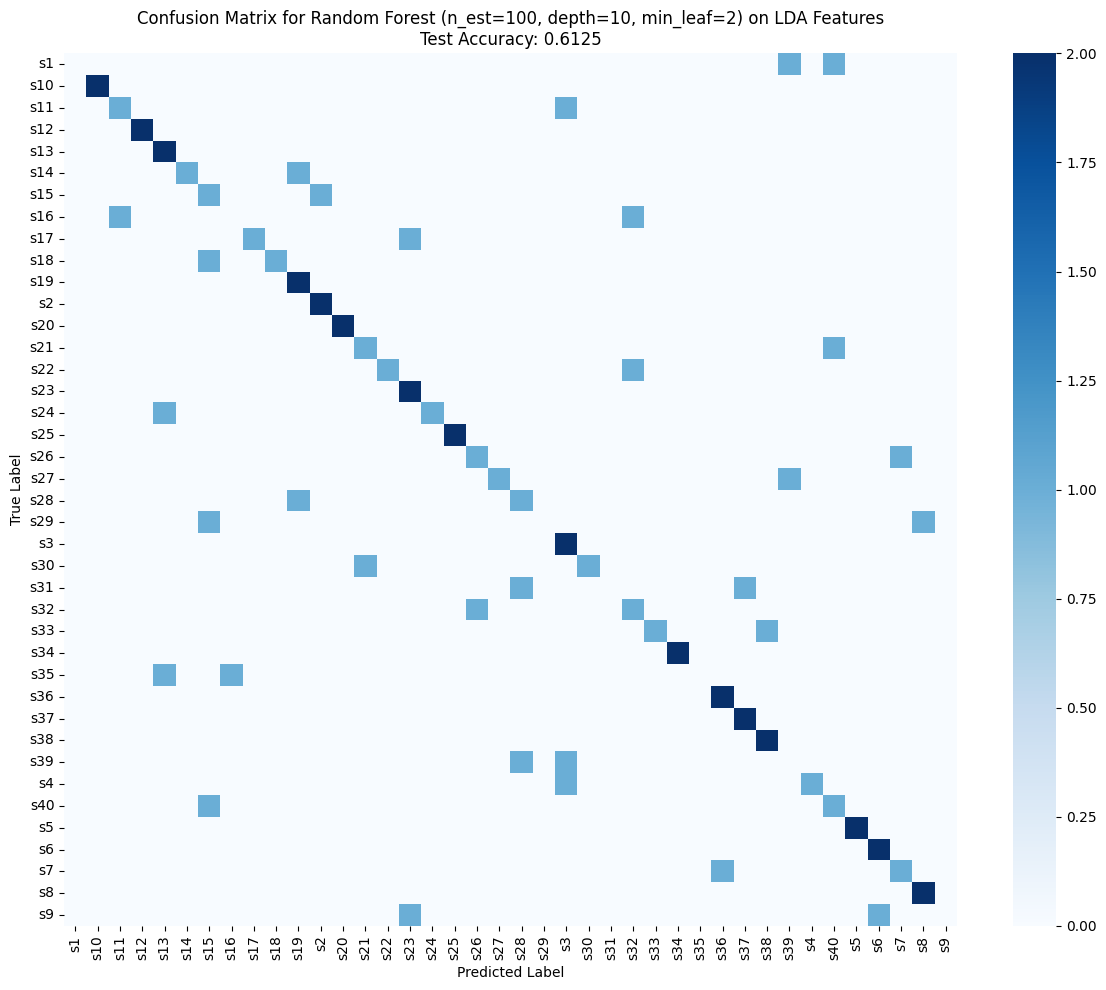

Graphical Confusion Matrix saved to: processed_faces_newFinal12\lda_analysis_results\plots\random_forest_confusion_matrix_tuned_depth10_leaf2.png

Random Forest Classifier model evaluation complete.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

plots_output_dir = os.path.join(lda_output_dir, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# --- Step 1: Load the LDA Features ---
print("Starting Random Forest Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values
y = df_lda_features['person_id'].values

# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- Step 4: Initialize and Train Random Forest Model ---
# Adjusting hyperparameters to reduce overfitting
n_estimators = 100
max_depth = 10         # Limiting the maximum depth of each tree
min_samples_leaf = 2   # Minimum samples required to be at a leaf node

print(f"Initializing Random Forest Classifier with n_estimators={n_estimators}, max_depth={max_depth}, min_samples_leaf={min_samples_leaf}...")
rf_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test = rf_model.predict(X_test)
print("Predictions on test set complete.")

print("Making predictions on the training set (for training accuracy)...")
y_pred_train = rf_model.predict(X_train)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- Random Forest Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Test Set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, zero_division=0))

# --- Graphical Confusion Matrix ---
print("\nGenerating graphical Confusion Matrix...")

class_labels = np.unique(y)
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=class_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Random Forest (n_est={n_estimators}, depth={max_depth}, min_leaf={min_samples_leaf}) on LDA Features\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout()

confusion_matrix_plot_path = os.path.join(plots_output_dir, f"random_forest_confusion_matrix_tuned_depth{max_depth}_leaf{min_samples_leaf}.png")
plt.savefig(confusion_matrix_plot_path)
plt.show()
plt.close()

print(f"Graphical Confusion Matrix saved to: {confusion_matrix_plot_path}")

print("\nRandom Forest Classifier model evaluation complete.")

Starting MLPClassifier Model Training and Evaluation...
Loading LDA features from: processed_faces_newFinal12\lda_analysis_results\lda_features.csv
Successfully loaded 396 samples.
Original labels mapped to: ['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']
Splitting data into training and testing sets (80% train, 20% test)...
Training samples: 316, Testing samples: 80
Feature dimension after LDA: 39
Scaling features using StandardScaler...
Feature scaling complete.
Initializing MLPClassifier...
Training MLPClassifier model (verbose output will show convergence progress)...
Iteration 1, loss = 3.93316034
Validation score: 0.031250
Iteration 2, loss = 3.85018032
Validation score: 0.031250
Iteration 3, loss = 3.77585867
Validation score: 0.031250
Iteration 4, loss = 3.70311349
Validation score: 0.031250
I

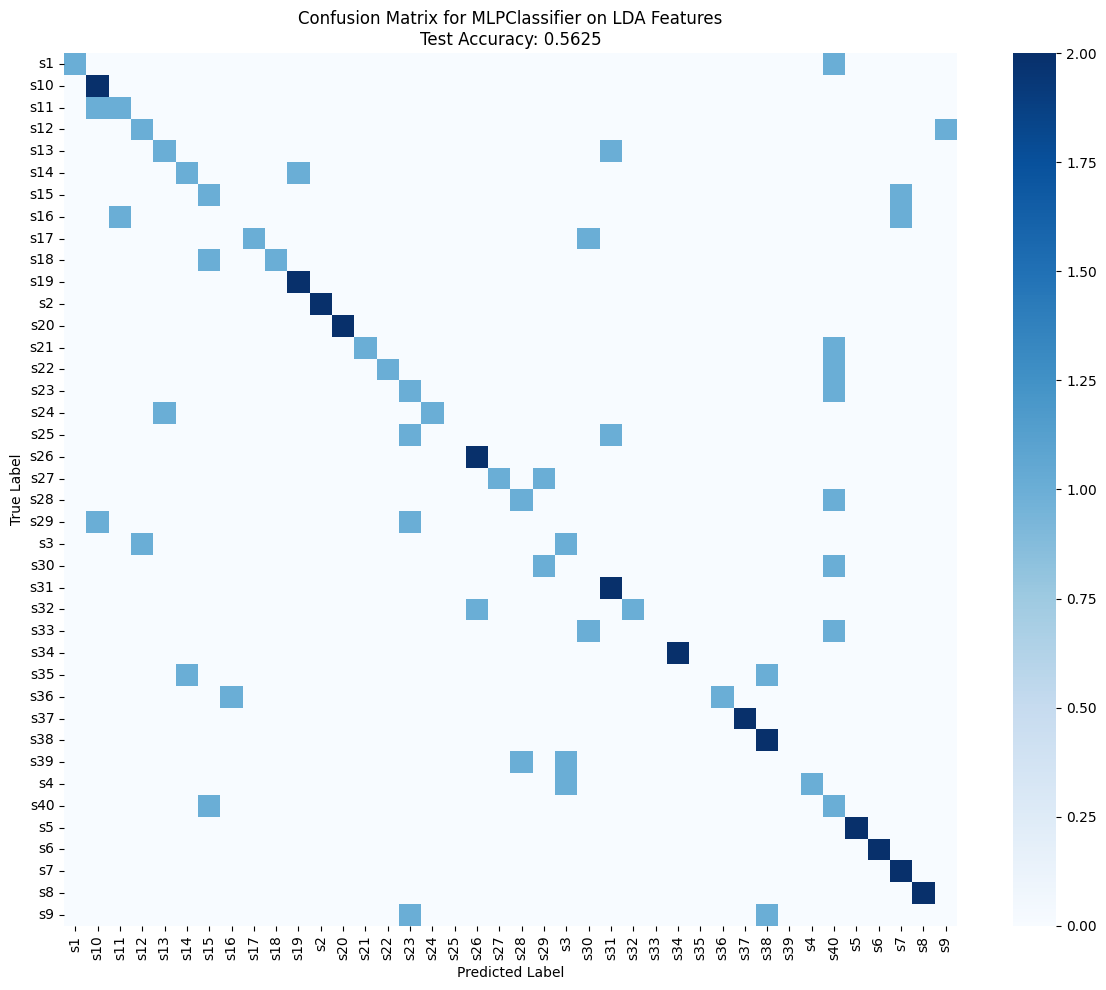

Graphical Confusion Matrix saved to: processed_faces_newFinal12\lda_analysis_results\plots\mlp_confusion_matrix.png

MLPClassifier model evaluation complete.


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier # Import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder # StandardScaler is crucial for MLPs
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Path to the LDA features CSV generated from the previous script
root_output_dir = "processed_faces_newFinal12"
lda_output_dir = os.path.join(root_output_dir, "lda_analysis_results")
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# Directory to save plots
plots_output_dir = os.path.join(lda_output_dir, "plots")
os.makedirs(plots_output_dir, exist_ok=True)

# --- Step 1: Load the LDA Features ---
print("Starting MLPClassifier Model Training and Evaluation...")
print(f"Loading LDA features from: {lda_features_csv_path}")

try:
    df_lda_features = pd.read_csv(lda_features_csv_path)
except FileNotFoundError:
    print(f"Error: LDA features CSV not found at {lda_features_csv_path}.")
    print("Please ensure the previous LDA script ran successfully and generated the file.")
    exit()

print(f"Successfully loaded {len(df_lda_features)} samples.")

# --- Step 2: Separate Features (X) and Labels (y) ---
feature_cols = [col for col in df_lda_features.columns if col.startswith('lda_feature_')]
X = df_lda_features[feature_cols].values  # Features
y = df_lda_features['person_id'].values   # Labels (person IDs)

# Optional: Encode labels to integers if not already numeric or if issues arise.
# MLPClassifier can often handle string labels directly, but explicit encoding
# can be safer/clearer for consistency, especially if using a numeric target.
# If you used LabelEncoder for XGBoost, keep this consistent.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_ # Store original class names for plotting

print(f"Original labels mapped to: {class_names}")


# --- Step 3: Train-Test Split ---
print("Splitting data into training and testing sets (80% train, 20% test)...")
# Use the encoded labels for stratification to ensure even distribution
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Feature dimension after LDA: {X_train.shape[1]}")

# --- IMPORTANT FOR MLP: Feature Scaling ---
# Scale features to mean 0 and variance 1. This is crucial for convergence and performance.
print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling complete.")

# --- Step 4: Initialize and Train MLP Model ---
# hidden_layer_sizes: Tuple, specifies the number of neurons in each hidden layer.
#                     (e.g., (100,) for one hidden layer with 100 neurons,
#                             (50, 50) for two hidden layers each with 50 neurons)
# activation: Activation function for the hidden layer (e.g., 'relu', 'logistic', 'tanh'). 'relu' is common.
# solver: Algorithm for weight optimization (e.g., 'adam', 'sgd', 'lbfgs'). 'adam' is robust.
# alpha: L2 regularization parameter (prevents overfitting).
# max_iter: Maximum number of iterations (epochs) to run. Increase if not converging.
# tol: Tolerance for the optimization. If loss doesn't improve by this much, stop.
# learning_rate_init: Initial learning rate for 'sgd' or 'adam'.
print("Initializing MLPClassifier...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
    activation='relu',          # Rectified Linear Unit activation function
    solver='adam',              # Adam optimizer
    alpha=0.0001,               # L2 regularization parameter
    max_iter=500,               # Maximum number of epochs
    random_state=42,
    verbose=True,               # Show training progress
    early_stopping=True,        # Stop if validation score doesn't improve
    n_iter_no_change=10,        # Number of epochs with no improvement to wait before stopping
    tol=1e-4                    # Tolerance for early stopping
)

print("Training MLPClassifier model (verbose output will show convergence progress)...")
mlp_model.fit(X_train_scaled, y_train_encoded)
print("MLPClassifier model training complete.")

# --- Step 5: Make Predictions ---
print("Making predictions on the test set...")
y_pred_test_encoded = mlp_model.predict(X_test_scaled)
print("Predictions on test set complete.")

print("Making predictions on the training set (for training accuracy)...")
y_pred_train_encoded = mlp_model.predict(X_train_scaled)
print("Predictions on training set complete.")

# --- Step 6: Evaluate Performance ---
print("\n--- MLPClassifier Model Evaluation ---")

# Training Accuracy
train_accuracy = accuracy_score(y_train_encoded, y_pred_train_encoded)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Testing Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_test_encoded)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification Report (Test Set) - Decode labels for report readability
print("\nClassification Report (Test Set):")
print(classification_report(
    y_test_encoded,
    y_pred_test_encoded,
    target_names=class_names, # Use original class names here
    zero_division=0
))

# --- Graphical Confusion Matrix ---
print("\nGenerating graphical Confusion Matrix...")

# Use the encoded labels for confusion matrix calculation, but original names for plotting
conf_matrix = confusion_matrix(y_test_encoded, y_pred_test_encoded, labels=range(len(class_names)))

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names, # Use original class names for labels
    yticklabels=class_names
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for MLPClassifier on LDA Features\nTest Accuracy: {test_accuracy:.4f}')
plt.tight_layout()

# Save the plot
confusion_matrix_plot_path = os.path.join(plots_output_dir, "mlp_confusion_matrix.png")
plt.savefig(confusion_matrix_plot_path)
plt.show()
plt.close()

print(f"Graphical Confusion Matrix saved to: {confusion_matrix_plot_path}")

print("\nMLPClassifier model evaluation complete.")